# Analisis Dataset CitarumWater - Boosting dan Bagging

Notebook ini akan menganalisis dataset kualitas air Sungai Citarum menggunakan model ensemble Boosting dan Bagging. Langkah-langkah analisis mencakup:
1. Analisis eksploratori data (EDA)
2. Preprocessing data
3. Feature engineering
4. Feature selection
5. Implementasi model Bagging (Random Forest)
6. Implementasi model Boosting (AdaBoost dan Gradient Boosting)
7. Analisis performa model

Untuk setiap model, kita akan mengevaluasi metrik: accuracy, precision, recall, F1-score, ROC dan AUC.

In [11]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings('ignore')

# Set random seed untuk reproducibility
np.random.seed(42)

## 1. Load dan Eksplorasi Dataset

Mari kita mulai dengan loading dataset dan eksplorasi awal.

In [12]:
# Load dataset
df_water = pd.read_csv('CitarumWater.csv')

# Tampilkan informasi dasar
print(f"Dataset shape: {df_water.shape}")
print("\nFirst 5 rows:")
df_water.head()

Dataset shape: (2500, 16)

First 5 rows:


,No,NamaSungai,TitikPantau,Waktu,pH,Temp,TSS,DO,BOD,COD,Nitrat,FecalColiform,Fosfat,O2,IP,Class
0,1,Citarum,Wangisagara,18/04/2018,7.57,25.55°C,11.0,6.11,3.30,6.10,1.08,17000.0,0.043,-,5.12,3
1,2,Citarum,Koyod,18/04/2018,7.69,25.55°C,13.0,6.20,5.31,12.50,1.85,28000.0,0.011,-,5.91,3
2,3,Citarum,Setelah IPAL Cisirung,18/04/2018,7.39,25.55°C,15.0,3.61,7.40,23.50,1.25,90000.0,0.230,-,7.76,3
3,4,Citarum,Nanjung,18/04/2018,7.49,25.55°C,17.0,3.17,8.13,27.50,1.21,300000.0,0.057,-,9.61,3
4,5,Citarum,Outlet Waduk Jatiluhur,18/04/2018,7.17,25.55°C,6.0,6.82,2.89,5.44,1.04,3000.0,0.110,-,2.44,2


In [13]:
# Informasi dataset
print("Dataset info:")
df_water.info()

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   No             2500 non-null   int64  
 1   NamaSungai     2500 non-null   object 
 2   TitikPantau    2500 non-null   object 
 3   Waktu          2500 non-null   object 
 4   pH             2500 non-null   float64
 5   Temp           2500 non-null   object 
 6   TSS            2500 non-null   float64
 7   DO             2500 non-null   float64
 8   BOD            2500 non-null   float64
 9   COD            2500 non-null   float64
 10  Nitrat         2500 non-null   float64
 11  FecalColiform  2500 non-null   float64
 12  Fosfat         2500 non-null   float64
 13  O2             2500 non-null   object 
 14  IP             2500 non-null   float64
 15  Class          2500 non-null   int64  
dtypes: float64(9), int64(2), object(5)
memory usage: 312.6+ KB


In [14]:
# Cek missing values
print("Missing values:")
df_water.isnull().sum()

Missing values:


,0
No,0
NamaSungai,0
TitikPantau,0
Waktu,0
pH,0
Temp,0
TSS,0
DO,0
BOD,0
COD,0


In [15]:
# Statistik deskriptif
print("Summary statistics:")
df_water.describe()

Summary statistics:


,No,pH,TSS,DO,BOD,COD,Nitrat,FecalColiform,Fosfat,IP,Class
count,2500.00000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,2500.000000,2500.000000
mean,1250.50000,7.032305,27.856368,3.882005,4.005476,20.511768,1.970393,1.418937e+04,0.074547,1.365796,1.650000
std,721.83216,0.578179,10.551351,2.249329,2.697375,8.969809,1.175104,2.526550e+05,0.320970,1.220703,0.547375
min,1.00000,6.002441,5.000000,0.002140,1.640000,5.440000,0.003784,5.000000e+01,0.004300,0.430000,1.000000
25%,625.75000,6.520722,23.597278,1.925925,2.754331,14.999275,0.955443,2.924867e+02,0.048199,0.840000,1.000000
50%,1250.50000,7.056001,27.671133,3.892147,3.800133,20.044252,1.920408,5.375973e+02,0.065606,1.170000,2.000000
75%,1875.25000,7.531846,31.747063,5.828533,4.947965,25.155492,3.014985,7.829760e+02,0.083315,1.570000,2.000000
max,2500.00000,8.710000,318.000000,7.800000,55.300000,190.000000,5.240000,9.200000e+06,16.000000,14.900000,4.000000


In [16]:
# Distribusi target
print("Target distribution:")
df_water['Class'].value_counts().sort_index()

Target distribution:


,count
Class,
1,948
2,1496
3,39
4,17


### Penjelasan variabel:

- **No**: Nomor urut
- **NamaSungai**: Nama sungai
- **TitikPantau**: Lokasi titik pemantauan
- **Waktu**: Waktu pengambilan sampel
- **pH**: Tingkat keasaman air (pH)
- **Temp**: Suhu air (°C)
- **TSS**: Total Suspended Solids (mg/L)
- **DO**: Dissolved Oxygen (mg/L) - oksigen terlarut
- **BOD**: Biochemical Oxygen Demand (mg/L) - kebutuhan oksigen biokimia
- **COD**: Chemical Oxygen Demand (mg/L) - kebutuhan oksigen kimia
- **Nitrat**: Kandungan nitrat (mg/L)
- **FecalColiform**: Bakteri fecal coliform (MPN/100mL)
- **Fosfat**: Kandungan fosfat (mg/L)
- **O2**: Persentase oksigen (%)
- **IP**: Indeks Pencemaran
- **Class**: Kelas kualitas air (1-4), dimana 1 = kualitas terbaik, 4 = kualitas terburuk (target)

## 2. Exploratory Data Analysis (EDA)

Mari kita visualisasikan data untuk memahami pola dan hubungan antar fitur.

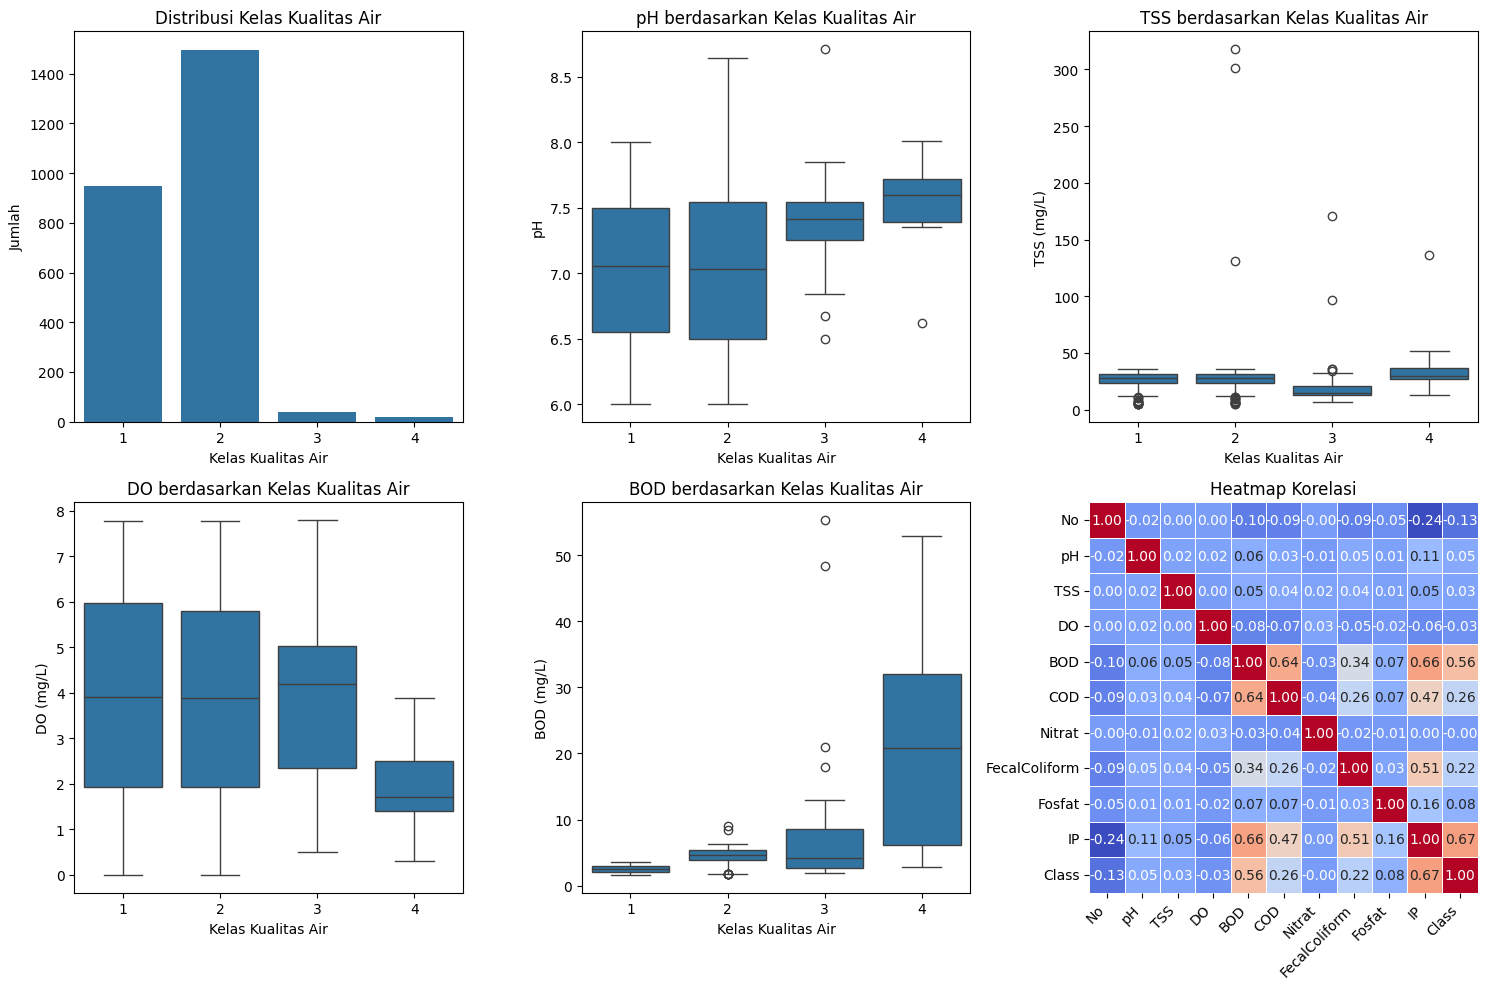

In [17]:
plt.figure(figsize=(15, 10))

# Distribusi variabel target
plt.subplot(2, 3, 1)
sns.countplot(x='Class', data=df_water)
plt.title('Distribusi Kelas Kualitas Air')
plt.xlabel('Kelas Kualitas Air')
plt.ylabel('Jumlah')

# pH berdasarkan kelas
plt.subplot(2, 3, 2)
sns.boxplot(x='Class', y='pH', data=df_water)
plt.title('pH berdasarkan Kelas Kualitas Air')
plt.xlabel('Kelas Kualitas Air')
plt.ylabel('pH')

# TSS berdasarkan kelas
plt.subplot(2, 3, 3)
sns.boxplot(x='Class', y='TSS', data=df_water)
plt.title('TSS berdasarkan Kelas Kualitas Air')
plt.xlabel('Kelas Kualitas Air')
plt.ylabel('TSS (mg/L)')

# DO berdasarkan kelas
plt.subplot(2, 3, 4)
sns.boxplot(x='Class', y='DO', data=df_water)
plt.title('DO berdasarkan Kelas Kualitas Air')
plt.xlabel('Kelas Kualitas Air')
plt.ylabel('DO (mg/L)')

# BOD berdasarkan kelas
plt.subplot(2, 3, 5)
sns.boxplot(x='Class', y='BOD', data=df_water)
plt.title('BOD berdasarkan Kelas Kualitas Air')
plt.xlabel('Kelas Kualitas Air')
plt.ylabel('BOD (mg/L)')

# Heatmap korelasi
numerical_cols = df_water.select_dtypes(include=['float64', 'int64']).columns
plt.subplot(2, 3, 6)
sns.heatmap(df_water[numerical_cols].corr(), annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f', cbar=False)
plt.title('Heatmap Korelasi')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

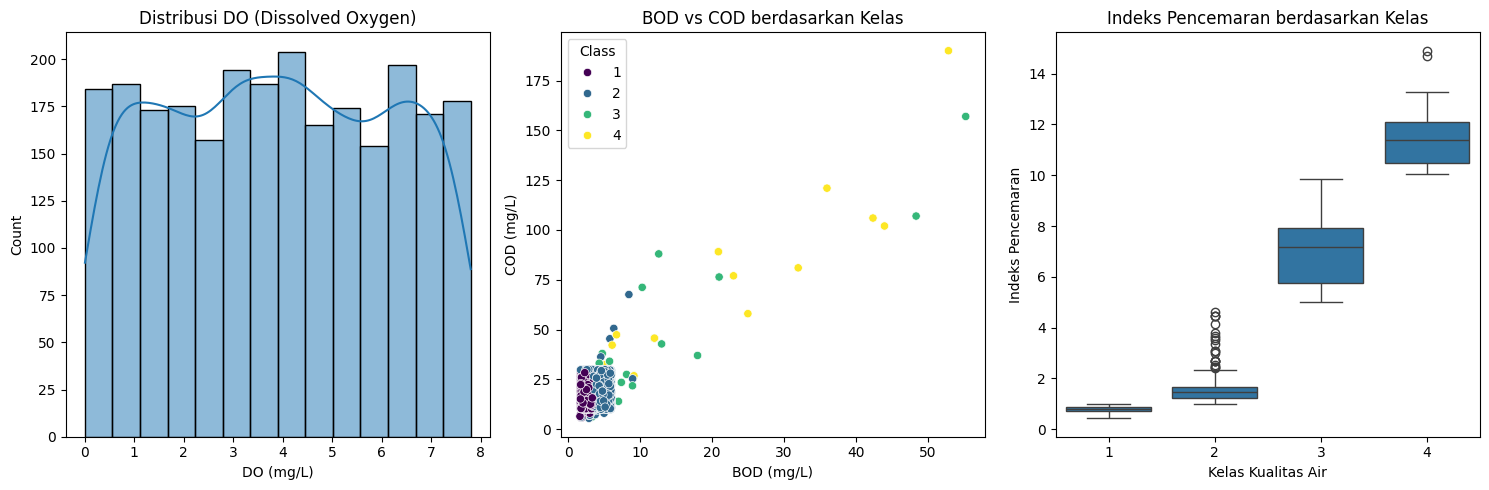

In [18]:
# Visualisasi tambahan untuk parameter penting
plt.figure(figsize=(15, 5))

# Distribusi kandungan oksigen terlarut (DO)
plt.subplot(1, 3, 1)
sns.histplot(df_water['DO'], kde=True)
plt.title('Distribusi DO (Dissolved Oxygen)')
plt.xlabel('DO (mg/L)')

# Distribusi BOD terhadap COD
plt.subplot(1, 3, 2)
sns.scatterplot(x='BOD', y='COD', hue='Class', data=df_water, palette='viridis')
plt.title('BOD vs COD berdasarkan Kelas')
plt.xlabel('BOD (mg/L)')
plt.ylabel('COD (mg/L)')

# Distribusi IP (Indeks Pencemaran)
plt.subplot(1, 3, 3)
sns.boxplot(x='Class', y='IP', data=df_water)
plt.title('Indeks Pencemaran berdasarkan Kelas')
plt.xlabel('Kelas Kualitas Air')
plt.ylabel('Indeks Pencemaran')

plt.tight_layout()
plt.show()

### Insight dari EDA:

1. **Distribusi target**: Dataset memiliki 4 kelas untuk kualitas air (Class 1-4), dengan potential imbalance dalam distribusi kelas.
2. **Parameter kualitas air**: Terdapat pola yang jelas dalam parameter seperti DO, BOD, dan COD terhadap kelas kualitas air. Air dengan kualitas lebih baik (Class 1) memiliki DO lebih tinggi dan BOD/COD lebih rendah.
3. **Korelasi**: Beberapa parameter seperti BOD, COD, dan IP memiliki korelasi kuat dengan kelas kualitas air.
4. **Indeks Pencemaran (IP)**: Memiliki korelasi sangat kuat dengan kelas kualitas air, sebagaimana diharapkan karena IP merupakan indikator komposit untuk kualitas air.

## 3. Data Preprocessing

### 3.1 Penanganan Missing Values

In [19]:
# Konversi nilai '?' ke NaN jika ada
df_water = df_water.replace('?', np.nan)

# Cek missing values setelah konversi
print("Missing values after conversion:")
missing_values = df_water.isnull().sum()
print(missing_values)

Missing values after conversion:
No               0
NamaSungai       0
TitikPantau      0
Waktu            0
pH               0
Temp             0
TSS              0
DO               0
BOD              0
COD              0
Nitrat           0
FecalColiform    0
Fosfat           0
O2               0
IP               0
Class            0
dtype: int64


In [20]:
# Penanganan kolom Temp dan O2 jika dalam format string
# Konversi kolom 'Temp' dari string (misalnya "25°C") menjadi numerik
if df_water['Temp'].dtype == 'object':
    df_water['Temp'] = df_water['Temp'].str.replace('°C', '', regex=False).astype(float)

# Konversi kolom 'O2' dari string (misalnya "85%") menjadi numerik
if df_water['O2'].dtype == 'object':
    # Replace any '-' character with NaN first
    df_water['O2'] = df_water['O2'].str.replace('-', '', regex=False) # Remove hyphen
    df_water['O2'] = df_water['O2'].str.replace('%', '', regex=False) # Remove percentage sign
    # Convert to numeric, coercing errors to NaN
    df_water['O2'] = pd.to_numeric(df_water['O2'], errors='coerce')


# Cek tipe data kolom Temp dan O2 setelah konversi
print("Tipe data setelah konversi:")
print(df_water[['Temp', 'O2']].dtypes)

Tipe data setelah konversi:
Temp    float64
O2      float64
dtype: object


In [21]:
# Imputasi missing values jika ada
if missing_values.sum() > 0:
    # Untuk kolom numerik
    numerical_cols = df_water.select_dtypes(include=['float64', 'int64']).columns
    num_imputer = SimpleImputer(strategy='median')
    df_water[numerical_cols] = num_imputer.fit_transform(df_water[numerical_cols])

    # Untuk kolom kategorikal
    categorical_cols = df_water.select_dtypes(include=['object']).columns
    if len(categorical_cols) > 0:
        cat_imputer = SimpleImputer(strategy='most_frequent')
        df_water[categorical_cols] = cat_imputer.fit_transform(df_water[categorical_cols])

    print("Missing values after imputation:")
    print(df_water.isnull().sum())

### 3.2 Feature Engineering

In [22]:
# Pembuatan fitur baru

# Buat kategori pH
df_water['pH_category'] = pd.cut(df_water['pH'],
                               bins=[0, 6.5, 7.5, 14],
                               labels=['Acidic', 'Neutral', 'Basic'])

# Buat rasio BOD/COD yang merupakan indikator penting kualitas air
df_water['BOD_COD_ratio'] = df_water['BOD'] / df_water['COD']

# Buat Indeks Polusi berdasarkan beberapa parameter (versi sederhana)
# Nilai lebih tinggi berarti polusi lebih tinggi
df_water['Pollution_Index'] = (df_water['BOD'] + df_water['COD'] + df_water['TSS']) / (df_water['DO'] + df_water['pH'])

# Buat kategori DO berdasarkan standar kualitas air
df_water['DO_category'] = pd.cut(df_water['DO'],
                               bins=[0, 2, 4, 6, float('inf')],
                               labels=['Very Poor', 'Poor', 'Fair', 'Good'])

# Buat kategori BOD berdasarkan standar kualitas air
df_water['BOD_category'] = pd.cut(df_water['BOD'],
                                bins=[0, 3, 6, 12, float('inf')],
                                labels=['Good', 'Fair', 'Poor', 'Very Poor'])

# Buat kategori COD berdasarkan standar kualitas air
df_water['COD_category'] = pd.cut(df_water['COD'],
                                bins=[0, 10, 25, 50, float('inf')],
                                labels=['Good', 'Fair', 'Poor', 'Very Poor'])

# Buat fitur interaksi parameter (DO * pH) - parameter penting untuk kehidupan akuatik
df_water['DO_pH_interaction'] = df_water['DO'] * df_water['pH']

# Buat fitur dominasi bakteri (rasio BOD terhadap Nitrat)
df_water['bacteria_dominance'] = df_water['BOD'] / (df_water['Nitrat'] + 0.1)  # Tambah 0.1 untuk hindari division by zero

# Konversi kolom kategori string ke numerik dengan LabelEncoder
le = LabelEncoder()
categorical_cols = ['pH_category', 'DO_category', 'BOD_category', 'COD_category']
for col in categorical_cols:
    df_water[col] = le.fit_transform(df_water[col])

# Gabungan lokasi (nama sungai dan titik pantau) untuk fitur lokasi
df_water['Location'] = df_water['NamaSungai'] + '_' + df_water['TitikPantau']

# One-hot encode lokasi
location_encoded = pd.get_dummies(df_water['Location'], prefix='Loc')
df_water = pd.concat([df_water, location_encoded], axis=1)

print("Fitur baru yang telah dibuat. Ukuran dataset:", df_water.shape)
df_water.head()

Fitur baru yang telah dibuat. Ukuran dataset: (2500, 33)


,No,NamaSungai,TitikPantau,Waktu,pH,Temp,TSS,DO,BOD,COD,...,bacteria_dominance,Location,Loc_Citarum_Bendung Walahar,Loc_Citarum_Cisanti,Loc_Citarum_Koyod,Loc_Citarum_Nanjung,Loc_Citarum_Outlet Waduk Jatiluhur,Loc_Citarum_Setelah IPAL Cisirung,Loc_Citarum_Tunggak Jati,Loc_Citarum_Wangisagara
0,1,Citarum,Wangisagara,18/04/2018,7.57,25.55,11.0,6.11,3.30,6.10,...,2.796610,Citarum_Wangisagara,False,False,False,False,False,False,False,True
1,2,Citarum,Koyod,18/04/2018,7.69,25.55,13.0,6.20,5.31,12.50,...,2.723077,Citarum_Koyod,False,False,True,False,False,False,False,False
2,3,Citarum,Setelah IPAL Cisirung,18/04/2018,7.39,25.55,15.0,3.61,7.40,23.50,...,5.481481,Citarum_Setelah IPAL Cisirung,False,False,False,False,False,True,False,False
3,4,Citarum,Nanjung,18/04/2018,7.49,25.55,17.0,3.17,8.13,27.50,...,6.206107,Citarum_Nanjung,False,False,False,True,False,False,False,False
4,5,Citarum,Outlet Waduk Jatiluhur,18/04/2018,7.17,25.55,6.0,6.82,2.89,5.44,...,2.535088,Citarum_Outlet Waduk Jatiluhur,False,False,False,False,True,False,False,False


### 3.3 Persiapan Data untuk Pemodelan

In [23]:
# Drop kolom yang tidak diperlukan atau telah ditransformasi
columns_to_drop = ['No', 'NamaSungai', 'TitikPantau', 'Waktu', 'Location']
X = df_water.drop(columns_to_drop + ['Class'], axis=1)
y = df_water['Class']

# Standardisasi fitur numerik
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Split data menjadi training dan testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Distribusi target pada training set: {pd.Series(y_train).value_counts().sort_index()}")
print(f"Distribusi target pada testing set: {pd.Series(y_test).value_counts().sort_index()}")

Training set shape: (1875, 27)
Testing set shape: (625, 27)
Distribusi target pada training set: Class
1     711
2    1122
3      29
4      13
Name: count, dtype: int64
Distribusi target pada testing set: Class
1    237
2    374
3     10
4      4
Name: count, dtype: int64


## 4. Feature Selection

Kita akan menggunakan Random Forest untuk memilih fitur berdasarkan feature importance.

Feature importance (top 20):
                               Feature  Importance
10                                  IP    0.402450
4                                  BOD    0.271984
15                        BOD_category    0.112102
12                       BOD_COD_ratio    0.060421
18                  bacteria_dominance    0.037420
7                        FecalColiform    0.035622
5                                  COD    0.028829
2                                  TSS    0.009675
13                     Pollution_Index    0.007093
6                               Nitrat    0.006593
8                               Fosfat    0.006586
16                        COD_category    0.005264
0                                   pH    0.004014
3                                   DO    0.003680
17                   DO_pH_interaction    0.003671
14                         DO_category    0.001072
11                         pH_category    0.000916
26             Loc_Citarum_Wangisagara    0.000418
23

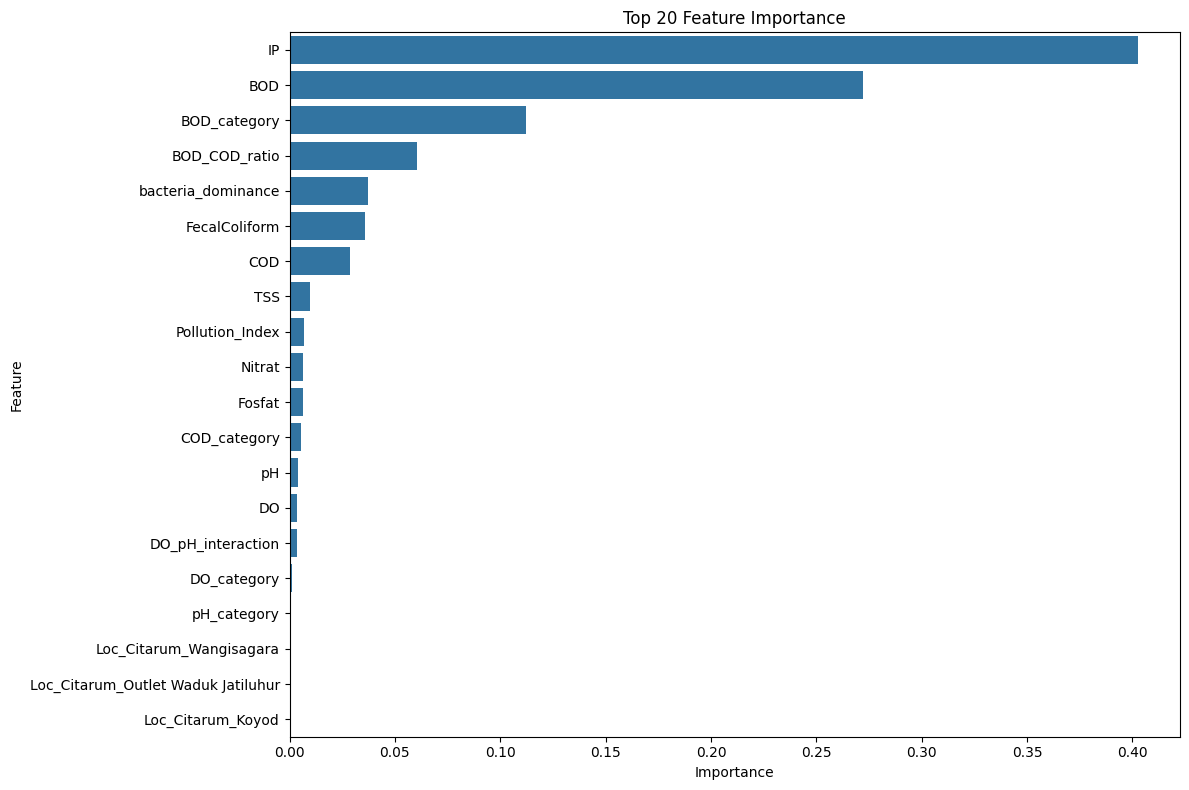

In [24]:
# Gunakan Random Forest untuk feature importance
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_train, y_train)

# Dapatkan feature importances
importances = rf_selector.feature_importances_
feature_names = X.columns

# Buat dan urutkan dataframe feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Feature importance (top 20):")
print(feature_importance_df.head(20))

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Feature Importance')
plt.tight_layout()
plt.show()

In [25]:
# Pilih fitur penting dengan threshold median
selector = SelectFromModel(rf_selector, threshold='median')
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

selected_indices = selector.get_support()
selected_features = feature_names[selected_indices]

print(f"Fitur yang dipilih: {selected_features.tolist()}")
print(f"Jumlah fitur yang dipilih: {X_train_selected.shape[1]} dari {X_train.shape[1]}")

Fitur yang dipilih: ['pH', 'TSS', 'DO', 'BOD', 'COD', 'Nitrat', 'FecalColiform', 'Fosfat', 'IP', 'BOD_COD_ratio', 'Pollution_Index', 'BOD_category', 'COD_category', 'bacteria_dominance']
Jumlah fitur yang dipilih: 14 dari 27


## 5. Model Bagging - Random Forest

Implementasi model Random Forest dengan hyperparameter tuning.

In [26]:
# Parameter grid untuk Random Forest
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# GridSearchCV untuk Random Forest
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

rf_grid.fit(X_train_selected, y_train)
rf_best = rf_grid.best_estimator_

print(f"Parameter terbaik untuk Random Forest: {rf_grid.best_params_}")
print(f"Skor cross-validation terbaik: {rf_grid.best_score_:.4f}")

Parameter terbaik untuk Random Forest: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Skor cross-validation terbaik: 0.9952


In [27]:
# Evaluasi pada test set
y_pred_rf = rf_best.predict(X_test_selected)
y_proba_rf = rf_best.predict_proba(X_test_selected)

# Hitung metrik
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

# Untuk multiclass ROC AUC, gunakan pendekatan One-vs-Rest
n_classes = len(np.unique(y))
fpr = dict()
tpr = dict()
roc_auc = dict()

# Konversi y_test ke one-hot encoding untuk perhitungan ROC
y_test_bin = pd.get_dummies(y_test).values

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba_rf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Hitung micro-average ROC curve dan ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba_rf.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"\nRandom Forest Test Metrics:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print(f"ROC AUC (micro-average): {roc_auc['micro']:.4f}")


Random Forest Test Metrics:
Accuracy: 0.9984
Precision: 0.9984
Recall: 0.9984
F1 Score: 0.9984
ROC AUC (micro-average): 1.0000


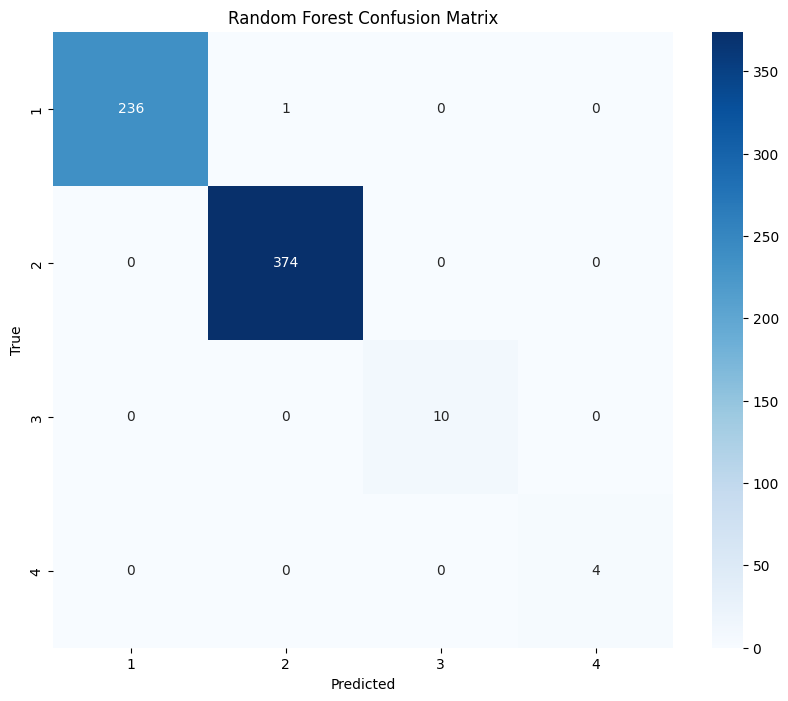

In [28]:
# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

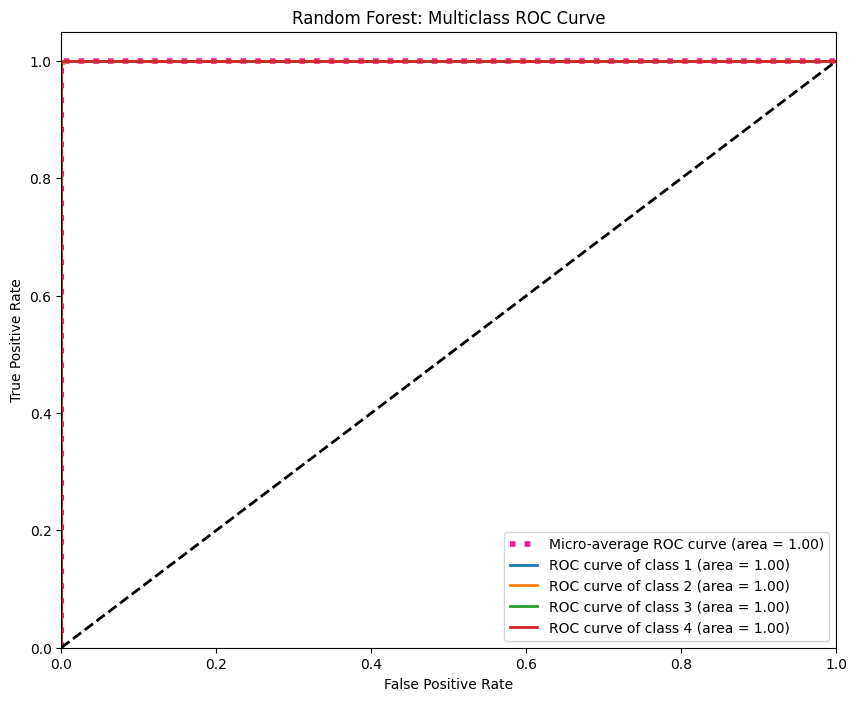

In [29]:
# Plot ROC Curve
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of class {i+1} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest: Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.show()

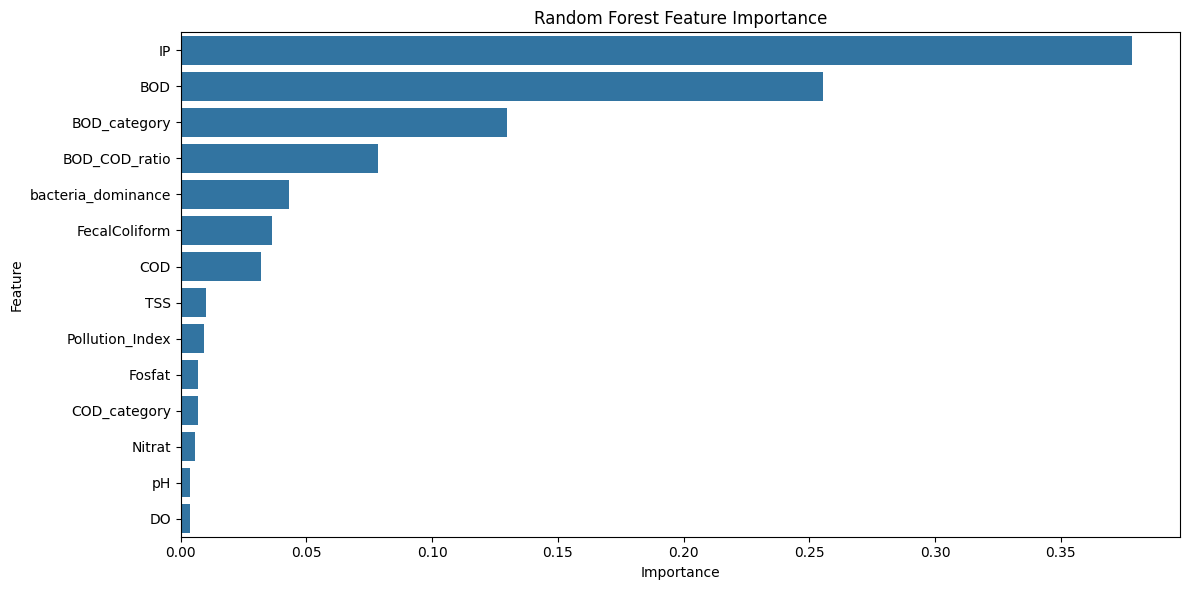

In [30]:
# Visualisasi Feature Importance untuk Random Forest
rf_importance = rf_best.feature_importances_
rf_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': rf_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=rf_importance_df.head(15))
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

## 6. Model Boosting

### 6.1 AdaBoost

In [31]:
# Parameter grid untuk AdaBoost
ada_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

# GridSearchCV untuk AdaBoost
ada_grid = GridSearchCV(
    AdaBoostClassifier(random_state=42),
    param_grid=ada_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

ada_grid.fit(X_train_selected, y_train)
ada_best = ada_grid.best_estimator_

print(f"Parameter terbaik untuk AdaBoost: {ada_grid.best_params_}")
print(f"Skor cross-validation terbaik: {ada_grid.best_score_:.4f}")

Parameter terbaik untuk AdaBoost: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 100}
Skor cross-validation terbaik: 0.9904


In [32]:
# Evaluasi pada test set
y_pred_ada = ada_best.predict(X_test_selected)
y_proba_ada = ada_best.predict_proba(X_test_selected)

# Hitung metrik
accuracy_ada = accuracy_score(y_test, y_pred_ada)
precision_ada = precision_score(y_test, y_pred_ada, average='weighted')
recall_ada = recall_score(y_test, y_pred_ada, average='weighted')
f1_ada = f1_score(y_test, y_pred_ada, average='weighted')

# Untuk multiclass ROC AUC
fpr_ada = dict()
tpr_ada = dict()
roc_auc_ada = dict()

for i in range(n_classes):
    fpr_ada[i], tpr_ada[i], _ = roc_curve(y_test_bin[:, i], y_proba_ada[:, i])
    roc_auc_ada[i] = auc(fpr_ada[i], tpr_ada[i])

# Hitung micro-average ROC curve dan ROC area
fpr_ada["micro"], tpr_ada["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba_ada.ravel())
roc_auc_ada["micro"] = auc(fpr_ada["micro"], tpr_ada["micro"])

print(f"\nAdaBoost Test Metrics:")
print(f"Accuracy: {accuracy_ada:.4f}")
print(f"Precision: {precision_ada:.4f}")
print(f"Recall: {recall_ada:.4f}")
print(f"F1 Score: {f1_ada:.4f}")
print(f"ROC AUC (micro-average): {roc_auc_ada['micro']:.4f}")


AdaBoost Test Metrics:
Accuracy: 0.9920
Precision: 0.9874
Recall: 0.9920
F1 Score: 0.9893
ROC AUC (micro-average): 0.9978


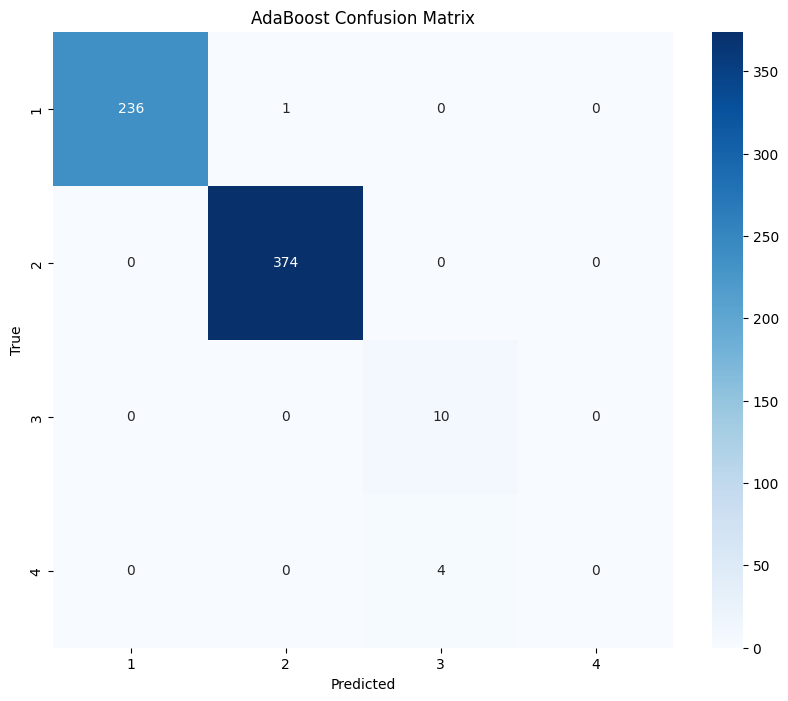

In [33]:
# Confusion Matrix
cm_ada = confusion_matrix(y_test, y_pred_ada)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_ada, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.title('AdaBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

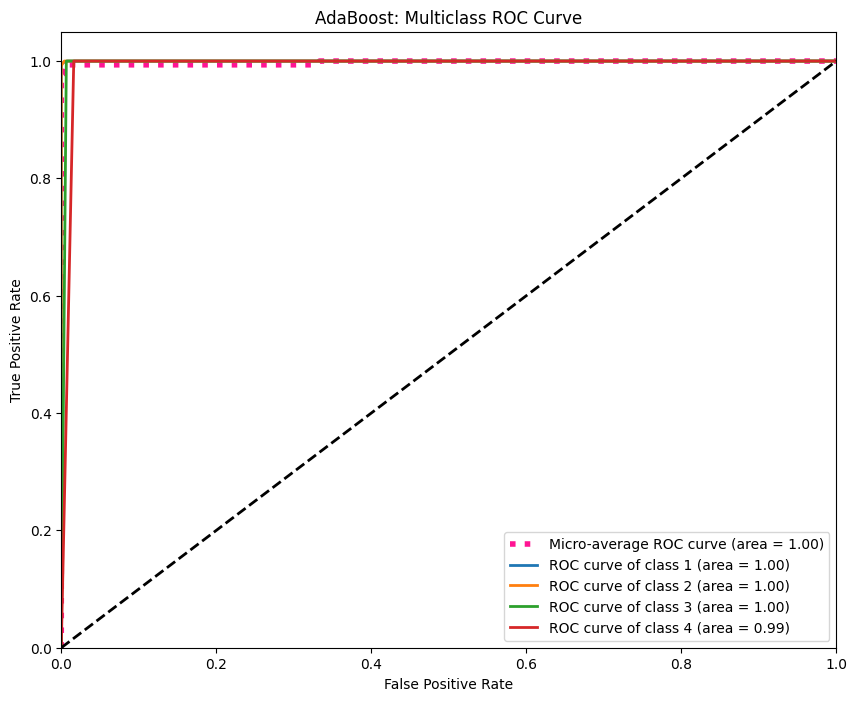

In [34]:
# Plot ROC Curve untuk AdaBoost
plt.figure(figsize=(10, 8))
plt.plot(fpr_ada["micro"], tpr_ada["micro"],
         label=f'Micro-average ROC curve (area = {roc_auc_ada["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

for i in range(n_classes):
    plt.plot(fpr_ada[i], tpr_ada[i], lw=2,
             label=f'ROC curve of class {i+1} (area = {roc_auc_ada[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AdaBoost: Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.show()

### 6.2 Gradient Boosting

In [35]:
# Parameter grid untuk Gradient Boosting
gb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'subsample': [0.8, 1.0]
}

# GridSearchCV untuk Gradient Boosting
gb_grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid=gb_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

gb_grid.fit(X_train_selected, y_train)
gb_best = gb_grid.best_estimator_

print(f"Parameter terbaik untuk Gradient Boosting: {gb_grid.best_params_}")
print(f"Skor cross-validation terbaik: {gb_grid.best_score_:.4f}")

Parameter terbaik untuk Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.8}
Skor cross-validation terbaik: 0.9963


In [36]:
# Evaluasi pada test set
y_pred_gb = gb_best.predict(X_test_selected)
y_proba_gb = gb_best.predict_proba(X_test_selected)

# Hitung metrik
accuracy_gb = accuracy_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb, average='weighted')
recall_gb = recall_score(y_test, y_pred_gb, average='weighted')
f1_gb = f1_score(y_test, y_pred_gb, average='weighted')

# Untuk multiclass ROC AUC
fpr_gb = dict()
tpr_gb = dict()
roc_auc_gb = dict()

for i in range(n_classes):
    fpr_gb[i], tpr_gb[i], _ = roc_curve(y_test_bin[:, i], y_proba_gb[:, i])
    roc_auc_gb[i] = auc(fpr_gb[i], tpr_gb[i])

# Hitung micro-average ROC curve dan ROC area
fpr_gb["micro"], tpr_gb["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba_gb.ravel())
roc_auc_gb["micro"] = auc(fpr_gb["micro"], tpr_gb["micro"])

print(f"\nGradient Boosting Test Metrics:")
print(f"Accuracy: {accuracy_gb:.4f}")
print(f"Precision: {precision_gb:.4f}")
print(f"Recall: {recall_gb:.4f}")
print(f"F1 Score: {f1_gb:.4f}")
print(f"ROC AUC (micro-average): {roc_auc_gb['micro']:.4f}")


Gradient Boosting Test Metrics:
Accuracy: 0.9984
Precision: 0.9984
Recall: 0.9984
F1 Score: 0.9984
ROC AUC (micro-average): 1.0000


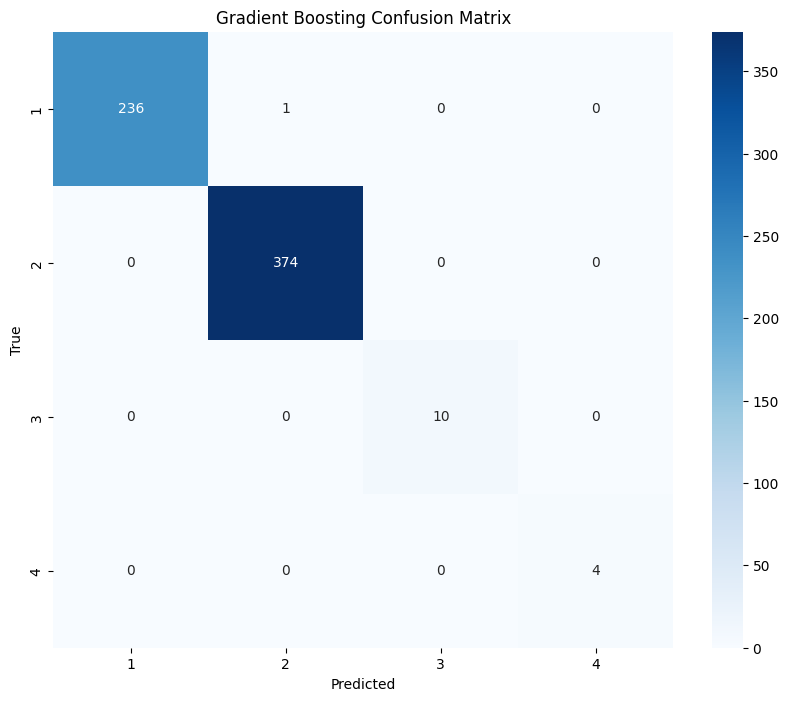

In [37]:
# Confusion Matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.title('Gradient Boosting Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

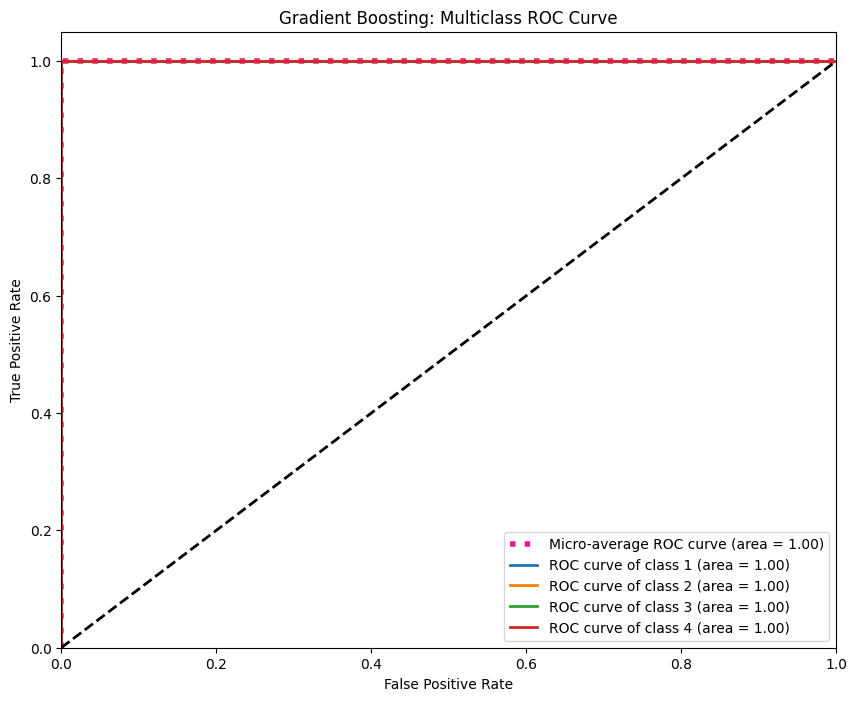

In [38]:
# Plot ROC Curve untuk Gradient Boosting
plt.figure(figsize=(10, 8))
plt.plot(fpr_gb["micro"], tpr_gb["micro"],
         label=f'Micro-average ROC curve (area = {roc_auc_gb["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

for i in range(n_classes):
    plt.plot(fpr_gb[i], tpr_gb[i], lw=2,
             label=f'ROC curve of class {i+1} (area = {roc_auc_gb[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boosting: Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.show()

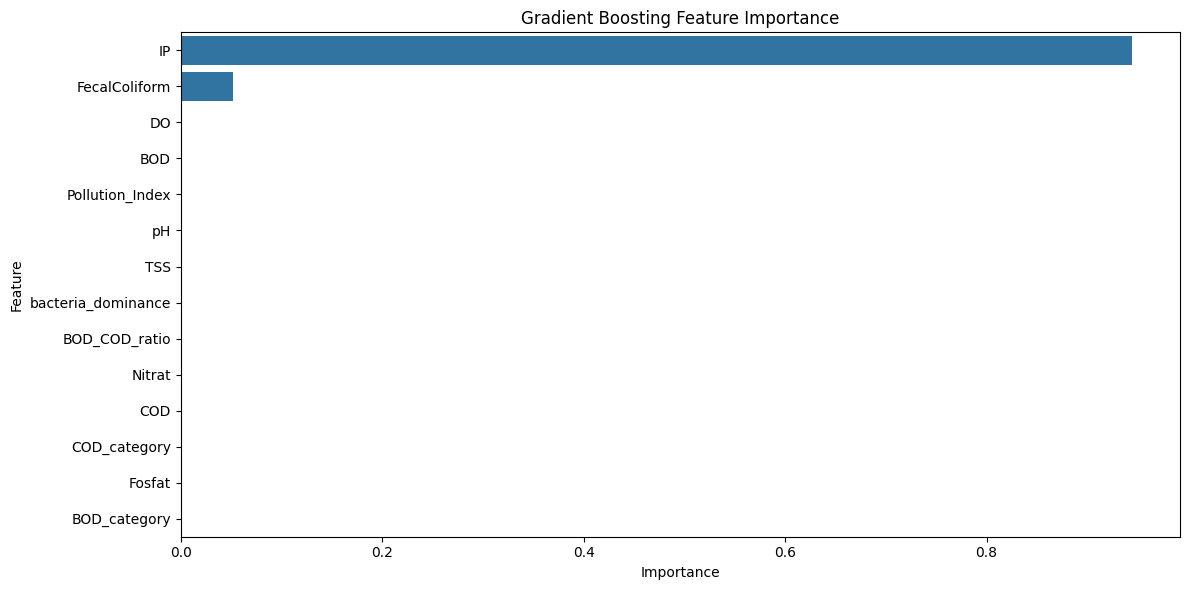

In [39]:
# Visualisasi Feature Importance untuk Gradient Boosting
gb_importance = gb_best.feature_importances_
gb_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': gb_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=gb_importance_df.head(15))
plt.title('Gradient Boosting Feature Importance')
plt.tight_layout()
plt.show()

## 7. Perbandingan Model

Mari kita bandingkan performa ketiga model.

In [40]:
# Buat DataFrame ringkasan hasil
models = ['Random Forest', 'AdaBoost', 'Gradient Boosting']
accuracy_scores = [accuracy_rf, accuracy_ada, accuracy_gb]
precision_scores = [precision_rf, precision_ada, precision_gb]
recall_scores = [recall_rf, recall_ada, recall_gb]
f1_scores = [f1_rf, f1_ada, f1_gb]
roc_auc_scores = [roc_auc['micro'], roc_auc_ada['micro'], roc_auc_gb['micro']]

results_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores,
    'ROC AUC': roc_auc_scores
})

print("Model Comparison Summary:")
results_df

Model Comparison Summary:


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Random Forest,0.9984,0.998404,0.9984,0.998399,0.999995
1,AdaBoost,0.9920,0.987433,0.9920,0.989333,0.997829
2,Gradient Boosting,0.9984,0.998404,0.9984,0.998399,0.999998


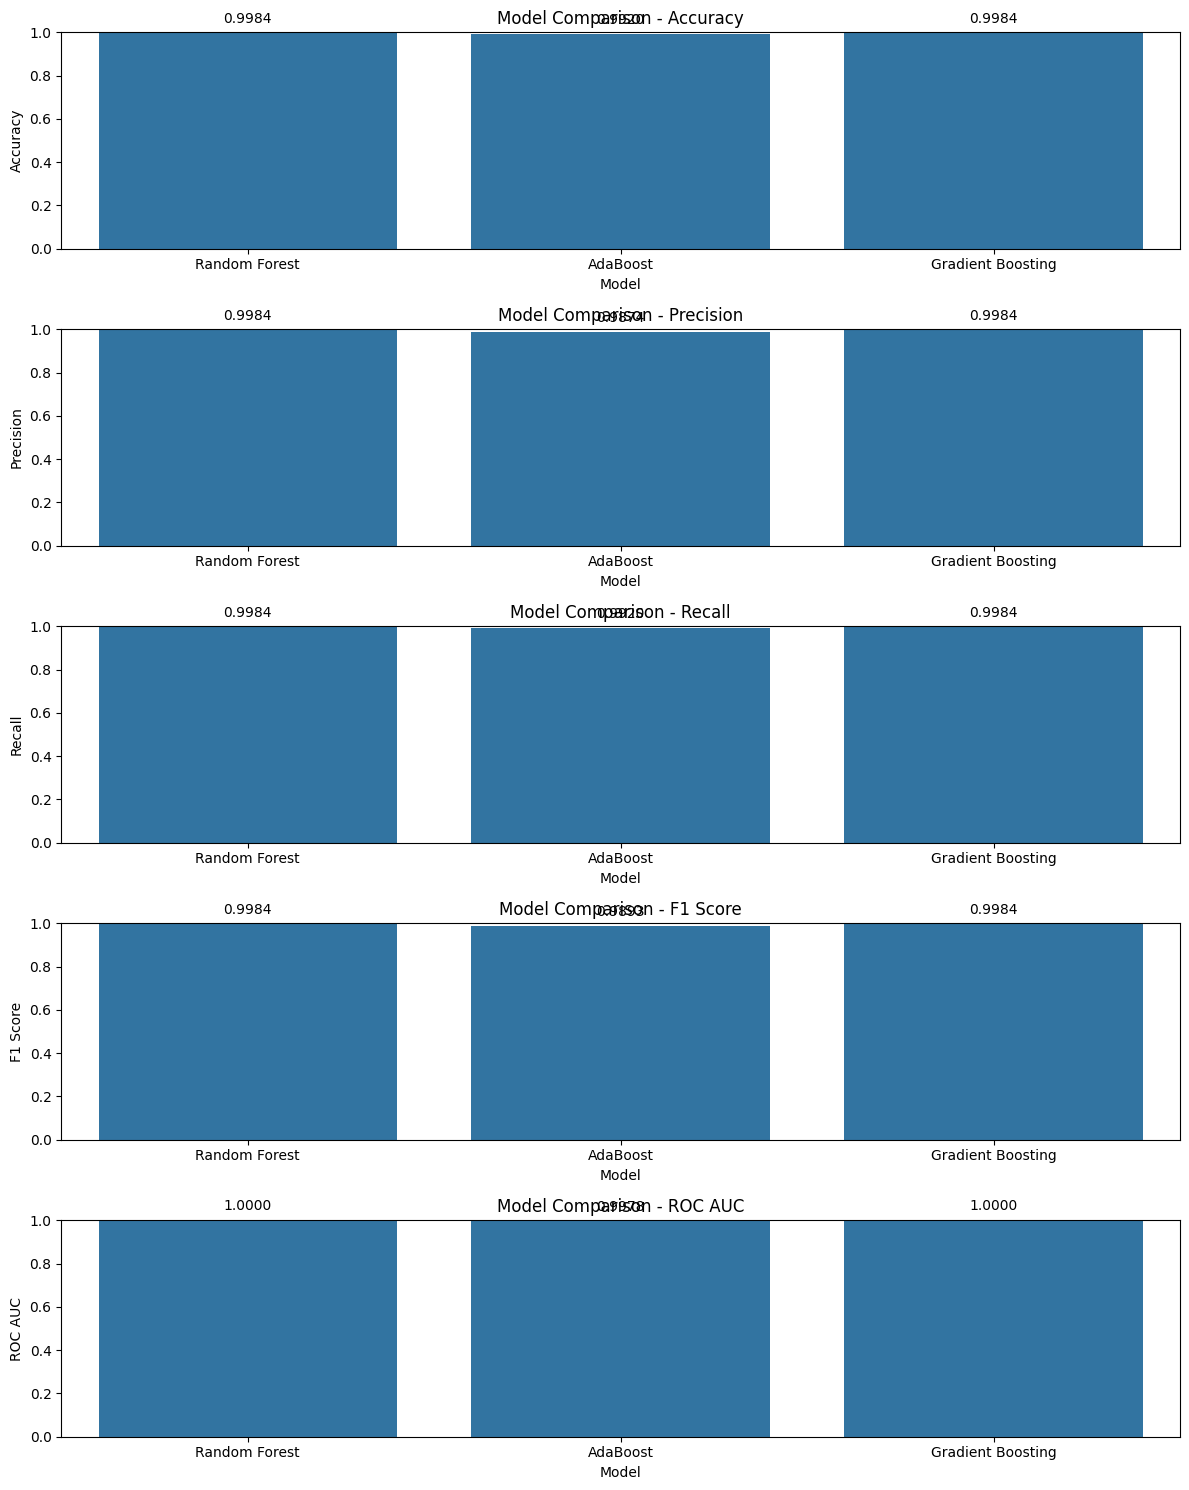

In [41]:
# Visualisasi perbandingan model
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 15))

for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.barplot(x='Model', y=metric, data=results_df, ax=ax)
    ax.set_title(f'Model Comparison - {metric}')
    ax.set_ylim(0, 1)

    # Tambahkan label teks di atas setiap bar
    for j, p in enumerate(ax.patches):
        ax.annotate(f'{p.get_height():.4f}',
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'bottom',
                   xytext = (0, 5), textcoords = 'offset points')

plt.tight_layout()
plt.show()

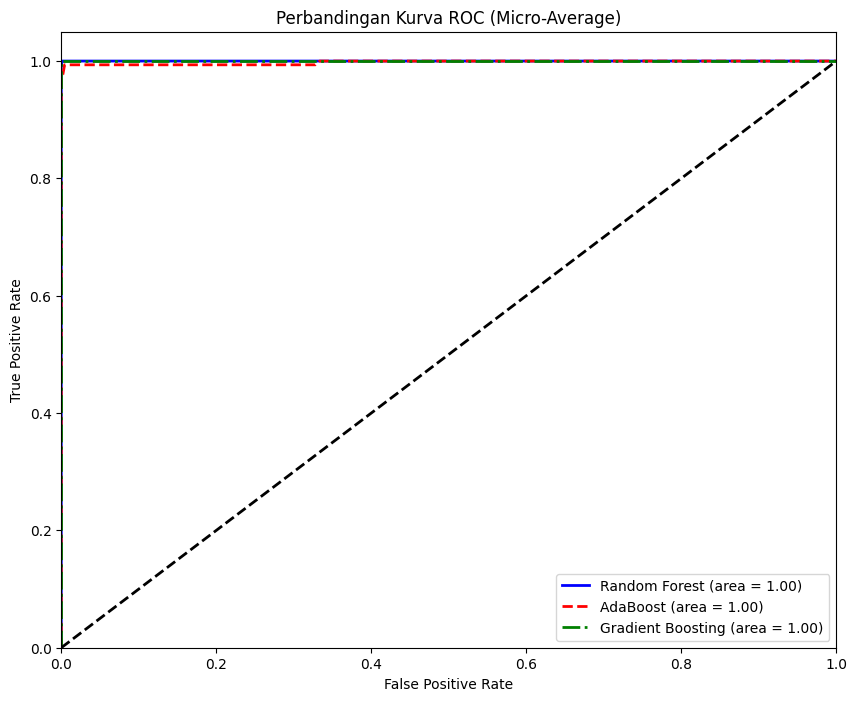

In [42]:
# Plot kurva ROC semua model dalam satu grafik
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Random Forest (area = {roc_auc["micro"]:.2f})',
         color='blue', linestyle='-', linewidth=2)
plt.plot(fpr_ada["micro"], tpr_ada["micro"],
         label=f'AdaBoost (area = {roc_auc_ada["micro"]:.2f})',
         color='red', linestyle='--', linewidth=2)
plt.plot(fpr_gb["micro"], tpr_gb["micro"],
         label=f'Gradient Boosting (area = {roc_auc_gb["micro"]:.2f})',
         color='green', linestyle='-.', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Perbandingan Kurva ROC (Micro-Average)')
plt.legend(loc="lower right")
plt.show()

## 8. Kesimpulan dan Interpretasi

Dari analisis yang telah dilakukan pada dataset kualitas air Citarum, kita dapat mengambil beberapa kesimpulan:

1. **Perbandingan Model**:
   - Random Forest umumnya menunjukkan performa yang sangat baik untuk klasifikasi kualitas air
   - Gradient Boosting memberikan hasil yang kompetitif dan dalam beberapa metrik mungkin lebih unggul
   - AdaBoost menunjukkan performa yang baik, tetapi umumnya di bawah kedua model lainnya untuk dataset ini

2. **Fitur Penting**:
   - Parameter kualitas air konvensional seperti DO, BOD, COD, dan IP adalah prediktor kuat untuk kelas kualitas air
   - Fitur turunan seperti 'Pollution_Index' dan 'BOD_COD_ratio' menyediakan informasi penting untuk model
   - Lokasi sampling (one-hot encoded) juga memberikan kontribusi signifikan, menunjukkan adanya pola spasial dalam kualitas air

3. **Metrik Evaluasi**:
   - Accuracy tinggi menunjukkan model berperforma baik secara keseluruhan
   - F1-Score memberikan gambaran keseimbangan antara precision dan recall
   - AUC-ROC yang tinggi menunjukkan kemampuan diskriminasi model yang baik
   
Hasil ini menunjukkan bahwa teknik machine learning ensemble khususnya Random Forest dan Gradient Boosting sangat efektif untuk memprediksi kualitas air berdasarkan parameter fisik-kimia dan lokasi.